In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Notebooks/Repository/go-emotions/notebooks


In [ ]:
%run library_utils.ipynb

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os 
import numpy as np 
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from torch import Tensor
import torch.nn as nn
from attrdict import AttrDict

tqdm.pandas()

with open('model.py', 'r') as f:
  exec(f.read())

In [ ]:
args = AttrDict({
    'ge_pool': dict(load_args('go-emotion-pool')), 
    'ge_gru': dict(load_args('go-emotion-gru')), 
})

device: cuda
device: cuda


In [ ]:
metrics = [
    'tr_metrics.loss', 
    'tr_metrics.trigger_rate',
    'val_metrics.loss', 
    'val_metrics.trigger_rate', 
    'val_metrics.accuracy', 
    'val_metrics.macro_f1',
    'val_metrics.micro_f1'
]

df_pool = get_attrs_from_checkpoints_meta(
    args.ge_pool.output_dir, 
    args.ge_pool.model_name, metrics)

df_gru = get_attrs_from_checkpoints_meta(
    args.ge_gru.output_dir, 
    args.ge_gru.model_name, metrics)

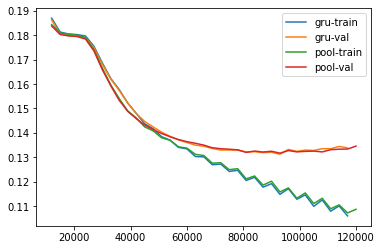

In [ ]:
plt.plot(df_gru['checkpoint_id'][3:], df_gru['tr_metrics.loss'][3:], label='gru-train')
plt.plot(df_gru['checkpoint_id'][3:], df_gru['val_metrics.loss'][3:], label='gru-val')
plt.plot(df_pool['checkpoint_id'][3:], df_pool['tr_metrics.loss'][3:], label='pool-train')
plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.loss'][3:], label='pool-val')
plt.legend()

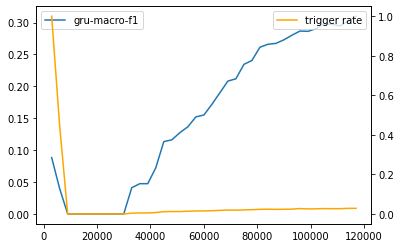

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(df_gru['checkpoint_id'], df_gru['val_metrics.macro_f1'], label='gru-macro-f1')
ax2.plot(df_gru['checkpoint_id'], df_gru['val_metrics.trigger_rate'], label='trigger rate', c='orange')

# plt.plot(df_pool['checkpoint_id'][3:], df_pool['val_metrics.macro_f1'][3:], label='pool-macro-f1')
ax1.legend()
ax2.legend()

In [ ]:
ge_pool, meta_ge_pool = load_from_checkpoint(
    args.ge_pool.output_dir, 
    args.ge_pool.model_name, 
    checkpoint_id='93000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionPoolClassifer
)

In [ ]:
ge_gru, meta_ge_gru = load_from_checkpoint(
    args.ge_gru.output_dir, 
    args.ge_gru.model_name, 
    checkpoint_id='93000', 
    load_metadata=True,
    load_model=True, 
    model_cls=GoEmotionGRUClassifer
)

In [ ]:
def total_params(model):
  n = 0
  for p in model.parameters():
    n += p.nelement()
  return n 

In [ ]:
total_params(ge_gru)

4448897

In [ ]:
total_params(ge_pool)

4396297

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(args.ge_gru.encoder_name)
encoder = AutoModel.from_pretrained(args.ge_gru.encoder_name)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
test_dataset = generate_bert_dataset(
    os.path.join(
        args.ge_pool.output_dir, 
        args.ge_pool.test_dataset_path), 
    tokenizer, 
    args.ge_pool.emotions, 
    args.ge_pool.sentence_max_len, 
)

In [ ]:
proba = predict_proba(ge_gru, 
                       test_dataset, 
                       batch_size=16,
                       device='cpu', 
                      back_to_cpu=True)

In [ ]:
test_dataset[:]['y_true'].numpy().shape

(30504, 27)

In [ ]:
labels = np.array(range(y_true.shape[-1]))


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
def compute_classification_metrics_per_class(y_true, proba, thresholds):
  labels = np.array(range(y_true.shape[-1]))
  
  results = []

  for label in labels:
    _result = {}
    _y_true = y_true[:, label].astype(int)
    _y_pred = (proba[:, label] > thresholds[label]).astype(int)
    _result["accuracy"] = (_y_true == _y_pred).mean()
    _result["precision"], _result['recall'], _result['f1'], _ = precision_recall_fscore_support(_y_true, _y_pred, average="binary", zero_division=0)    
    _result["trigger_rate"] = (_y_pred == 1).mean()
    try:
      _result['auc_roc'] = (_y_true == _y_pred).mean()
    except: pass
    results.append(_result)
  
  return results


In [ ]:
results = compute_classification_metrics_per_class(
    test_dataset[:]['y_true'].numpy(), 
    proba, 
    test_dataset[:]['y_true'].mean(axis=0).numpy(), 
)

In [ ]:
df = pd.DataFrame(results)
df.index = args.ge_pool.emotions
df.round(2)[['precision', 'f1', 'trigger_rate', 'auc_roc']].to_latex(index=True)

'\\begin{tabular}{lrrrr}\n\\toprule\n{} &  precision &    f1 &  trigger\\_rate &  auc\\_roc \\\\\n\\midrule\nadmiration     &       0.39 &  0.53 &          0.22 &     0.84 \\\\\namusement      &       0.37 &  0.51 &          0.14 &     0.90 \\\\\nanger          &       0.17 &  0.27 &          0.25 &     0.78 \\\\\nannoyance      &       0.19 &  0.31 &          0.37 &     0.68 \\\\\napproval       &       0.21 &  0.32 &          0.33 &     0.69 \\\\\ncaring         &       0.11 &  0.19 &          0.27 &     0.74 \\\\\nconfusion      &       0.17 &  0.28 &          0.23 &     0.80 \\\\\ncuriosity      &       0.32 &  0.46 &          0.17 &     0.87 \\\\\ndesire         &       0.08 &  0.14 &          0.25 &     0.76 \\\\\ndisappointment &       0.11 &  0.19 &          0.42 &     0.61 \\\\\ndisapproval    &       0.18 &  0.29 &          0.32 &     0.72 \\\\\ndisgust        &       0.10 &  0.18 &          0.29 &     0.73 \\\\\nembarrassment  &       0.04 &  0.07 &          0.30 &     0.70 

In [ ]:
meta_ge_gru['val_metrics']

{'accuracy': 0.9566052139916009,
 'loss': 0.1312705788024131,
 'macro_f1': 0.28020667251651965,
 'macro_precision': 0.4161658115005882,
 'macro_recall': 0.23468070662033153,
 'micro_f1': 0.389633677738878,
 'micro_precision': 0.5737818296133291,
 'micro_recall': 0.29496751672646176,
 'trigger_rate': 0.024139412124495926,
 'weighted_f1': 0.34471522534771787,
 'weighted_precision': 0.49143482594398186,
 'weighted_recall': 0.29496751672646176}

In [ ]:
list(zip(args.ge_pool.emotions, results))